# Homework 2

Compute Homographies Between Images

(-0.5, 449.5, 445.5, -0.5)

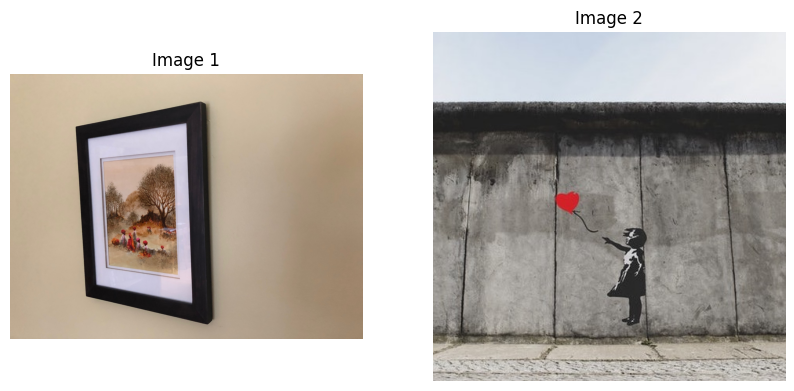

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1 = cv2.cvtColor(cv2.imread("Images/image1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("Images/image2.jpg"), cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1,2,figsize=(10,10))

%matplotlib inline
ax[0].imshow(img1)
ax[0].title.set_text("Image 1")
ax[0].axis('off')
ax[1].imshow(img2)
ax[1].title.set_text("Image 2")
ax[1].axis('off')

## Problem 1
Image1 shows a picture on a wall. Our goal is to replace that picture with Image2.
In order to do this we will compute the H matrix that defines the transformation between the two images and then map image2 in place on image1. 

We will use the four corner points in each image to setup the
computation of the H matrix and then map every pixel as needed.

In [3]:
def click_get_pixel_coords(image, num_inputs):
    # open in GUI to select points - pip install PyQt5
    %matplotlib qt
    
    fig = plt.figure().set_size_inches(10,12)
    plt.imshow(image)
    plt.axis('off')
    pts_selected = plt.ginput(num_inputs, timeout=60)
    pts_selected = np.array(pts_selected).astype(int) # convert to integer pixel
    plt.close()

    # revert to inline
    %matplotlib inline 
    return pts_selected
    

Image 1 Corner Pixel Coordinates Selected: 
 [[ 532  500]
 [ 928  461]
 [ 956 1140]
 [ 563 1085]]
Image 2 Corner Pixel Coordinates: 
 [[  0   0]
 [450   0]
 [450 446]
 [  0 446]]


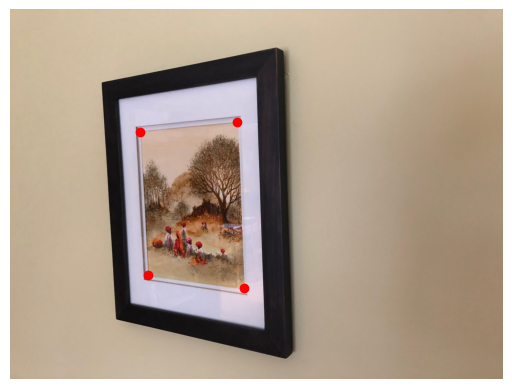

In [70]:
# Manually select four corners of image 1
img1_corners = click_get_pixel_coords(img1, 4)

# Plot corners on image
plt.imshow(img1)
plt.scatter(img1_corners[:,0],img1_corners[:,1], c='r') # draw point on image
plt.axis('off')

# Use the four corners of image 2
img2_corners = np.array([[0,0],
                         [img2.shape[1], 0],
                         [img2.shape[1], img2.shape[0]],
                         [0, img2.shape[0]]])

print("Image 1 Corner Pixel Coordinates Selected: \n", img1_corners)
print("Image 2 Corner Pixel Coordinates: \n", img2_corners)

### Direct Linear Transform (DLT) Algorithm - Multiview Geometry ch 4.1
For each set of points a system of equations can be produced, where $x'$ is the source point and $x$ is the destination point in homogeneous coordinates.<br>
$ x' = Hx$<br>

$ x = [x\ y\ 1]^T$ &emsp;  $ x' = [x'\ y'\ 1]^T$<br><br>
With a cross-product, it can be rewritten in the form $ Ah = 0 $<br>
$ h = [h_1\ h_2\ h_3\ h_4\ h_5\ h_6\ h_7\ h_8\ h_9]^T$ &emsp; $ H = \begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$

**A** is a 2x9 matrix:<br><br>
$ A = \begin{bmatrix} 0^T & -w'_i \mathbf x_i^T & y'_i \mathbf x_i^T \\ 
                    w'_i \mathbf x_i^T & 0^T & -x'_i \mathbf x_i^T  \end{bmatrix}$

The A Matrix, when expanded and setting the scaling/homogeneous term to 1, takes the form:<br><br>
$ A = \begin{bmatrix} 0 & 0 & 0 & -x & -y & -1 & xy' & yy' & y' \\ x & y & 1 & 0 & 0 & 0 & -xx' & -yx' & -x'  \end{bmatrix}$



In [4]:
# Homography Function
def get_homography(src_pts, dst_pts):
    # Create array of A matrices for each point
    A = np.zeros((len(dst_pts)*2,9))
    for i in range(len(dst_pts)):
        A[2*i] = [0.0, 0.0, 0.0, -src_pts[i,0], -src_pts[i,1], -1.0,
                   src_pts[i,0]*dst_pts[i,1], src_pts[i,1]*dst_pts[i,1], dst_pts[i,1]]
        A[2*i+1] = [src_pts[i,0], src_pts[i,1], 1.0, 0.0, 0.0, 0.0,
                   -src_pts[i,0]*dst_pts[i,0], -src_pts[i,1]*dst_pts[i,0], -dst_pts[i,0]]
        
    # Singular Value Decomposition
    _,_,Vt = np.linalg.svd(A)

    # select the last singular vector of V as the solution to H
    h = Vt.T[:,-1].reshape(3,3)
    h = h / h[2,2] # normalize to set bottom right val to 1.0
    return h

In [72]:
h = get_homography(img2_corners, img1_corners)
print("H Matrix: \n", h)

# Verify we get the correct H Matrix using OpenCV's Find Homography Function
h, status = cv2.findHomography(img2_corners, img1_corners)
print("\nOpenCV H Matrix Solution Check:\n", h)

H Matrix: 
 [[ 5.91568560e-01  9.17218483e-02  5.32000000e+02]
 [-2.29949957e-01  1.35447164e+00  5.00000000e+02]
 [-3.10809741e-04  3.94584758e-05  1.00000000e+00]]

OpenCV H Matrix Solution Check:
 [[ 5.91568560e-01  9.17218484e-02  5.32000000e+02]
 [-2.29949957e-01  1.35447164e+00  5.00000000e+02]
 [-3.10809741e-04  3.94584759e-05  1.00000000e+00]]


Use OpenCV's Warp Image function to apply the homograpy transformation matrix to the images

(-0.5, 2015.5, 1511.5, -0.5)

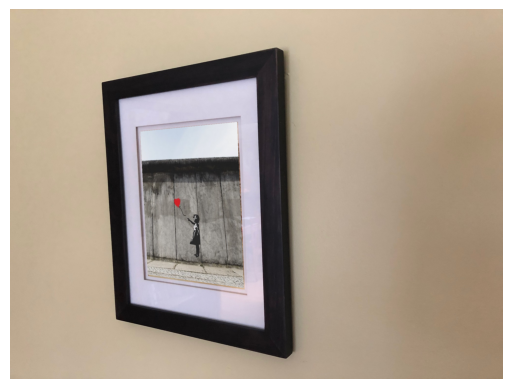

In [73]:
# https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87
cv2.warpPerspective(src=img2, # Source Image
                    M=h, # Homography Transformation Matrix
                    dsize=(img1.shape[1],img1.shape[0]), # Size of output image
                    dst=img1,  # Destination output image
                    borderMode=cv2.BORDER_TRANSPARENT) #  corresponding pixels in the destination image will not be modified at all
plt.imshow(img1)
plt.axis('off')

## Problem 2
Pick four additional points from the two images and modify the computation of the H matrix to account for an over constrained problem (8 points as opposed to 4). 

Recompute H with these 8 points and comment on the differences in the H matrix. 

Image 1 Corner Pixel Coordinates Selected: 
 [[ 535  500]
 [ 720  482]
 [ 930  461]
 [ 943  823]
 [ 956 1143]
 [ 738 1114]
 [ 563 1088]
 [ 548  823]]
Image 2 Corner Pixel Coordinates: 
 [[  0.   0.]
 [225.   0.]
 [450.   0.]
 [450. 223.]
 [450. 446.]
 [225. 446.]
 [  0. 446.]
 [  0. 223.]]


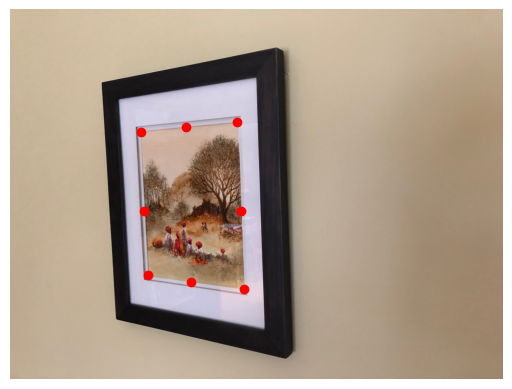

In [74]:
img1 = cv2.cvtColor(cv2.imread("Images/image1.jpg"), cv2.COLOR_BGR2RGB) # Re-import

# Select 8 points around the image border clockwise from top-left
img1_corners = click_get_pixel_coords(img1, 8)

print("Image 1 Corner Pixel Coordinates Selected: \n", img1_corners)
plt.imshow(img1)
plt.scatter(img1_corners[:,0],img1_corners[:,1], c='r') # draw point on image
plt.axis('off')

img2_corners = np.array([[0,0],
                         [img2.shape[1]/2, 0],
                         [img2.shape[1], 0],
                         [img2.shape[1], img2.shape[0]/2],
                         [img2.shape[1], img2.shape[0]],
                         [img2.shape[1]/2, img2.shape[0]],
                         [0, img2.shape[0]],
                         [0, img2.shape[0]/2]])
print("Image 2 Corner Pixel Coordinates: \n", img2_corners)

In [75]:
h = get_homography(img2_corners, img1_corners)
print("H Matrix: \n", h)

# Verify we get the correct H Matrix using OpenCV's Find Homography Function
h, status = cv2.findHomography(img2_corners, img1_corners)
print("\nOpenCV H Matrix Solution Check:\n", h)

H Matrix: 
 [[ 5.96894506e-01  1.79765536e-01  5.29871836e+02]
 [-2.53700788e-01  1.50281930e+00  5.06296291e+02]
 [-3.31730408e-04  1.73067618e-04  1.00000000e+00]]

OpenCV H Matrix Solution Check:
 [[ 6.02908321e-01  1.83960643e-01  5.29165158e+02]
 [-2.46856044e-01  1.50769341e+00  5.05178382e+02]
 [-3.24628954e-04  1.74265191e-04  1.00000000e+00]]


(-0.5, 2015.5, 1511.5, -0.5)

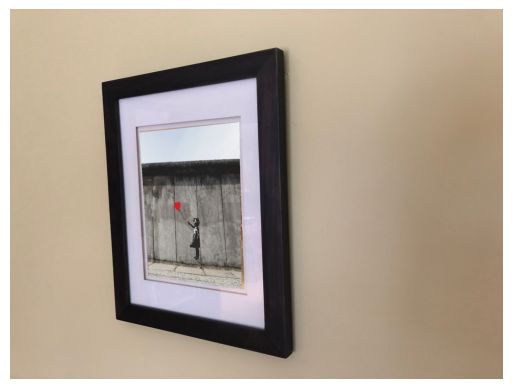

In [76]:
# https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87
cv2.warpPerspective(src=img2, # Source Image
                    M=h, # Homography Transformation Matrix
                    dsize=(img1.shape[1],img1.shape[0]), # Size of output image
                    dst=img1,  # Destination output image
                    borderMode=cv2.BORDER_TRANSPARENT) #  corresponding pixels in the destination image will not be modified at all
plt.imshow(img1)
plt.axis('off')

### Apply Homography Transformation using custom image

(-0.5, 2015.5, 1511.5, -0.5)

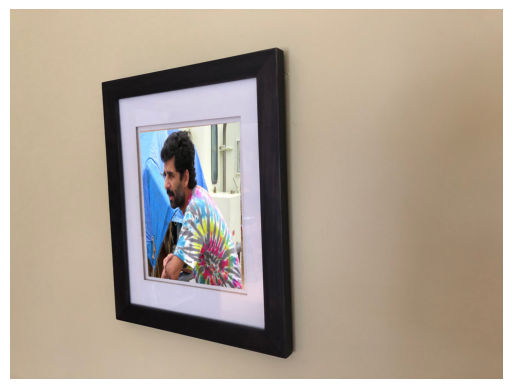

In [77]:
img1 = cv2.cvtColor(cv2.imread("Images/image1.jpg"), cv2.COLOR_BGR2RGB) # reimport
img3 = cv2.cvtColor(cv2.imread("Images/hanu.jpg"), cv2.COLOR_BGR2RGB)
img3_corners = np.array([[0,0],
                         [img3.shape[1]/2, 0],
                         [img3.shape[1], 0],
                         [img3.shape[1], img3.shape[0]/2],
                         [img3.shape[1], img3.shape[0]],
                         [img3.shape[1]/2, img3.shape[0]],
                         [0, img3.shape[0]],
                         [0, img3.shape[0]/2]])

h = get_homography(img3_corners, img1_corners)

cv2.warpPerspective(src=img3, # Source Image
                    M=h, # Homography Transformation Matrix
                    dsize=(img1.shape[1],img1.shape[0]), # Size of output image
                    dst=img1,  # Destination output image
                    borderMode=cv2.BORDER_TRANSPARENT) #  corresponding pixels in the destination image will not be modified at all
plt.imshow(img1)
plt.axis('off')

### Over-Determined Solution Discussion
For an over-determined solution, as discussed extensively in **Multiview Geometry Ch 4.1.1**, an exact solution for h is only possible if the position of the points is exact. Because of user inputs, precise point selection is not expected, causing noise. This leads to the need to find an approximate solution that minimizes a suitable cost function. SVD also works in this case, where the solution is the unit singular vector corresponding to the smallest singular value of A.

# Problem 3
Take multiple images and stitch them together into a mosaic

(-0.5, 3071.5, 4079.5, -0.5)

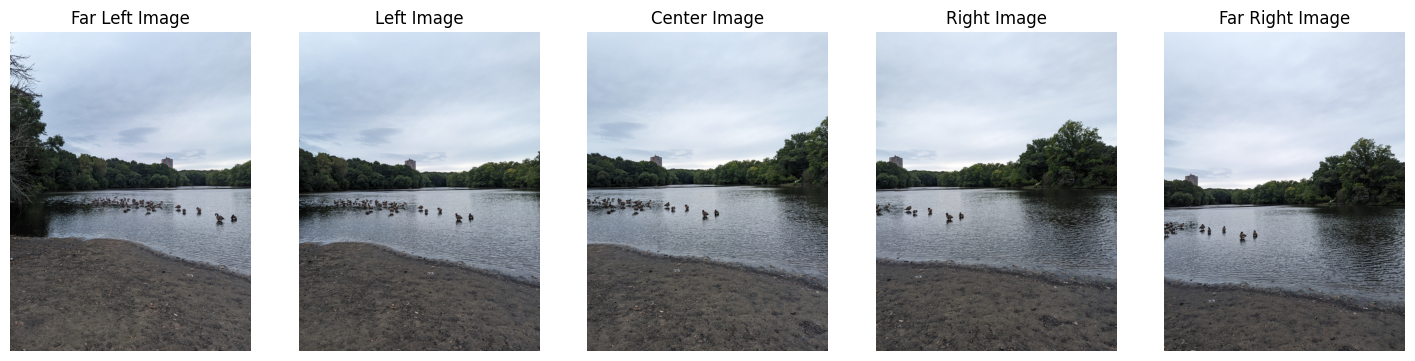

In [5]:
# Import Images
img_c = cv2.cvtColor(cv2.imread("images/img_c.jpg"), cv2.COLOR_BGR2RGB)
img_r = cv2.cvtColor(cv2.imread("images/img_r.jpg"), cv2.COLOR_BGR2RGB)
img_rr = cv2.cvtColor(cv2.imread("images/img_rr.jpg"), cv2.COLOR_BGR2RGB)
img_l = cv2.cvtColor(cv2.imread("images/img_l.jpg"), cv2.COLOR_BGR2RGB)
img_ll = cv2.cvtColor(cv2.imread("images/img_ll.jpg"), cv2.COLOR_BGR2RGB)

f, ax = plt.subplots(1,5,figsize=(18,18))
plt.axis('off')
ax[0].imshow(img_ll)
ax[0].title.set_text("Far Left Image")
ax[0].axis('off')
ax[1].imshow(img_l)
ax[1].title.set_text("Left Image")
ax[1].axis('off')
ax[2].imshow(img_c)
ax[2].title.set_text("Center Image")
ax[2].axis('off')
ax[3].imshow(img_r)
ax[3].title.set_text("Right Image")
ax[3].axis('off')
ax[4].imshow(img_rr)
ax[4].title.set_text("Far Right Image")
ax[4].axis('off')

The images below were taken from Olmsted Park across a pond and labeled as far left (ll), left (l), center (c), right (r), and far right (rr).

The same Four keypoints were manually selected in each image. They were chosen to avoid colinearity and retain a healthy distance between points.

In [6]:
# Select pixel coordinates on each image
pts_c = click_get_pixel_coords(img_c, 4)
pts_r = click_get_pixel_coords(img_r, 4)
pts_l = click_get_pixel_coords(img_l, 4)
pts_rr = click_get_pixel_coords(img_rr, 4)
pts_ll = click_get_pixel_coords(img_ll, 4)

(-0.5, 3071.5, 4079.5, -0.5)

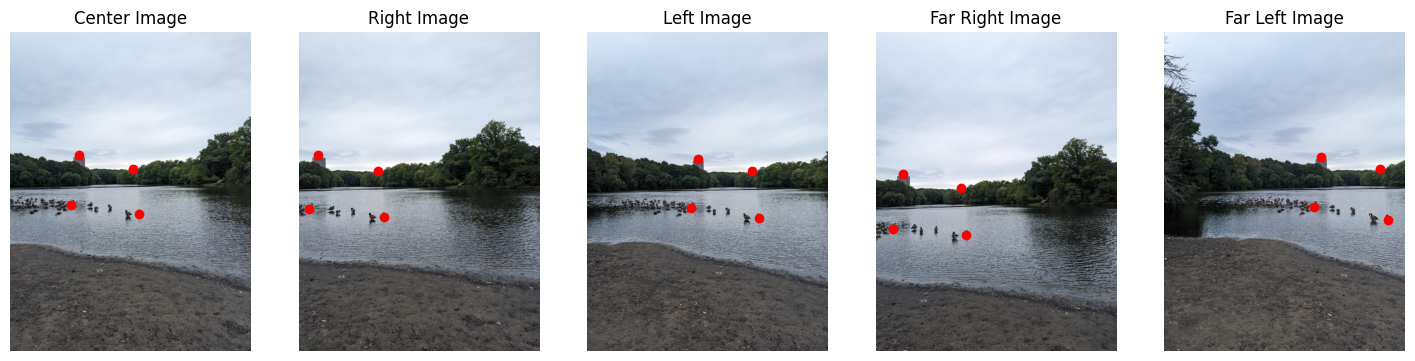

In [7]:
# plot results of selected pixel coordinates
f, ax = plt.subplots(1,5,figsize=(18,18))
ax[0].imshow(img_c)
ax[0].scatter(pts_c[:,0],pts_c[:,1], c='r')
ax[0].title.set_text("Center Image")
ax[0].axis('off')
ax[1].imshow(img_r)
ax[1].scatter(pts_r[:,0],pts_r[:,1], c='r')
ax[1].title.set_text("Right Image")
ax[1].axis('off')
ax[2].imshow(img_l)
ax[2].scatter(pts_l[:,0],pts_l[:,1], c='r')
ax[2].title.set_text("Left Image")
ax[2].axis('off')
ax[3].imshow(img_rr)
ax[3].scatter(pts_rr[:,0],pts_rr[:,1], c='r')
ax[3].title.set_text("Far Right Image")
ax[3].axis('off')
ax[4].imshow(img_ll)
ax[4].scatter(pts_ll[:,0],pts_ll[:,1], c='r')
ax[4].title.set_text("Far Left Image")
ax[4].axis('off')

Below are the functions for stitching images together and for adjusting the image frame correspondingly

Blend performed using: https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html

In [8]:
def adjust_image_frame(H, src_shape, dst_shape):
    # Get corners of the source image
    (h, w) = src_shape
    img_corners = np.float32([[0, 0],
                            [w - 1, 0],
                            [w - 1, h - 1],
                            [0, h - 1]])
    
    # Convert to Array in Homogeneous Coordinates
    corners_base = np.array([img_corners[:, 0],
                            img_corners[:,1],
                            np.ones(4)])

    # Calculate distorted corner pixel coordinates by multiplying by Homography matrix
    corners_distorted = np.dot(H, corners_base)
    [x, y, c] = corners_distorted
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the distorted image frame
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    # Fit Right Side of Image
    w_stitched = max(max_x, dst_shape[1])
    h_stitched = max(max_y, dst_shape[0])

    # Add offset if distorted stitching goes out of current image frame
    offset = [0, 0]
    if min_x < 0:
        offset[0] = abs(min_x)
        w_stitched += offset[0]
    if min_y < 0:
        offset[1] = abs(min_y)
        h_stitched += offset[1]

    # Add offset to stitched corner coordinates
    corners_stitched = np.float32(np.array([x + offset[0], y + offset[1]]).transpose())

    # Recompute homography s.t. the source image is in frame
    H = get_homography(img_corners, corners_stitched)
    
    return [h_stitched, w_stitched], offset, H


def stitch_images(img_dst, img_src, H):
    # Finding size of new frame of stitched images and updating the homography matrix 
    stitched_dims, offset, H = adjust_image_frame(H, img_src.shape[:2], img_dst.shape[:2])

    # Finally placing the images upon one another.
    src_warped = cv2.warpPerspective(img_src, H, (stitched_dims[1], stitched_dims[0]))

    # Expand destimation image frame to fit source image
    dst_transformed = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    dst_transformed[offset[1]:offset[1]+img_dst.shape[0], offset[0]:offset[0]+img_dst.shape[1]] = img_dst

    # Blend images together
    black = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    mask_dst = cv2.inRange(dst_transformed, np.array([0,0,0]), np.array([0,0,0]))
    mask_src = cv2.inRange(src_warped, np.array([0,0,0]), np.array([0,0,0]))

    # Get the non-overlapping components of both images
    dst_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_dst)
    src_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_src)

    # Get the overlapping region and set it to white to use as a mask
    overlap_region = cv2.bitwise_and(
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_dst)),
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_src)))
    overlap_region[overlap_region>0.0] = 255

    # Blend only the overlapping regions of the image
    img_overlap_blend = cv2.addWeighted(
        cv2.bitwise_or(src_warped, black, mask=overlap_region), 0.5,
        cv2.bitwise_or(dst_transformed, black, mask=overlap_region), 0.5, 0.0)

    # Combine all components of the image together
    img_stitched = dst_fringe + src_fringe + img_overlap_blend

    return img_stitched, offset

Using the center image as the starting point, iteratively stitch and blend the remaining images.

Display the final Panorama

(-0.5, 6151.5, 6374.5, -0.5)

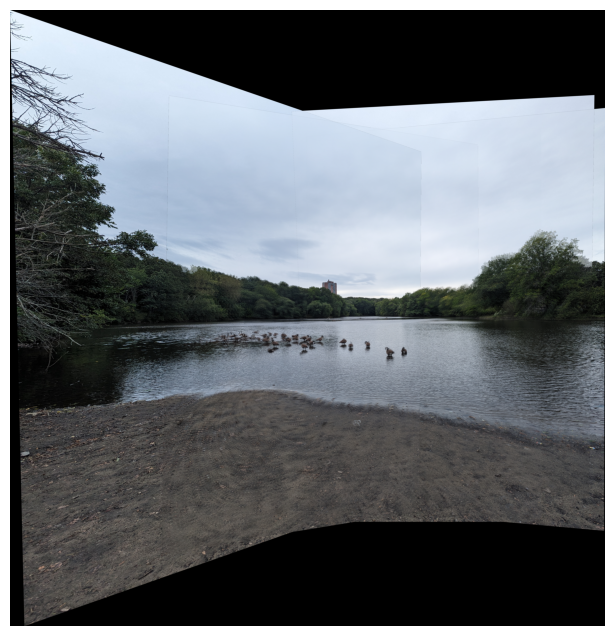

In [10]:
# save images and corresponding selected points in arrays
imgs = [img_r, img_l, img_rr, img_ll]
pts = [pts_r, pts_l, pts_rr, pts_ll]

# use center image as reference
img_base = img_c
c_pts = np.copy(pts_c)

# stitch each image together and blend into a single panorama
for i in range(len(imgs)):
    # Get homography transformation matrix relative to center image
    H = get_homography(pts[i], c_pts)

    # Blend together images
    StitchedImage, pts_pix_correction = stitch_images(img_base, imgs[i], H)
    
    # Compute adjusted center pixel coordinates based on frame change
    c_pts += pts_pix_correction
    img_base = StitchedImage.copy()    

plt.figure(figsize = (8,8))
plt.imshow(img_base)
plt.axis('off')

### Image Blending Technique Discussion

Image Pyramids and Blending: Burt and Adelson<br>
http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/Pyramids.pdf

The addWeighted function in OpenCV is a very simple blend that takes two images and adds them together according to a defined proportion, $\alpha$. 
In contrast, the paper by Burt and Adelson uses a Fast Fourier Transform (FFT) to perform a more robust blending technique. This method decomposes the left and right images into *octaves* that it combines ("feathers") together. A Laplacian Pyramid is formed from these octaves, whose number of levels can be varied to yield a different blend result. An inverse fourier transform can be performed to arrive at the final blended image.